In [1]:
import mujoco_py
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import rpy2r,pr2t,t2pr

import cv2

np.set_printoptions(precision=2)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Done.
Ready.


### Parsing `UR5e`

In [2]:
env = MuJoCoParserClass(name='UR5e',xml_path='../asset/ur5e/object_depth.xml')
print ("[%s] parsed."%(env.name))

[UR5e] parsed.


### Get camera informations

In [3]:
cam_infos = env.set_cam_infos(cam_distance  = 1.5,
                    cam_azimuth   = 0.0,
                    cam_elevation = -90.0,
                    cam_lookat    = [0.6,0,1.4])
cam_infos

{'cam_distance': 1.5,
 'cam_azimuth': 0.0,
 'cam_elevation': -90.0,
 'cam_lookat': array([0.6, 0. , 1.4])}

### Render a scene

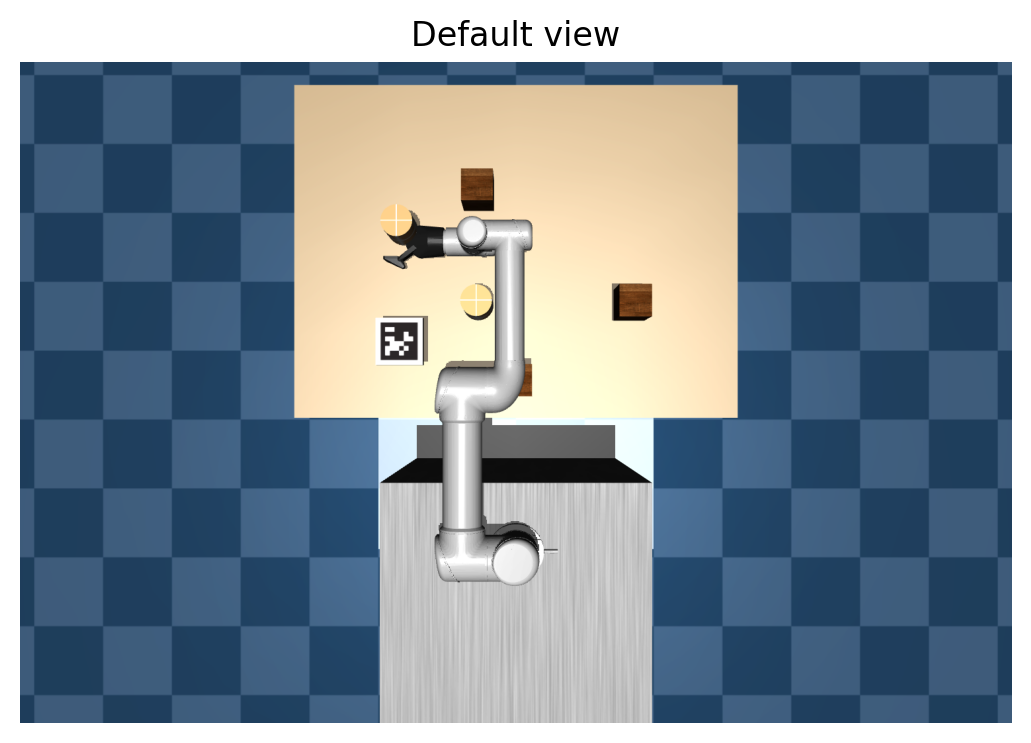

In [4]:
width = 1500
height = 1000

for _ in range(2):
    img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=False, camera_name="track")

plt.imshow(img); plt.axis('off')
plt.title("Default view")
plt.show()

### Get camera pose 

In [5]:
render_w = 1500
render_h = 1000

cam_matrix, cam_trans, cam_rot = env.camera_matrix_and_pose(render_w, render_h, camera_name="main1")
env.camera_matrix_and_pose(render_w, render_h, camera_name="main1")

(array([[1.21e+03, 0.00e+00, 7.50e+02],
        [0.00e+00, 1.21e+03, 5.00e+02],
        [0.00e+00, 0.00e+00, 1.00e+00]]),
 array([[ 0.69,  0.64,  0.33],
        [-0.33,  0.69, -0.64],
        [-0.64,  0.33,  0.69]]),
 array([2. , 2. , 2.7]))

## Rotate camera

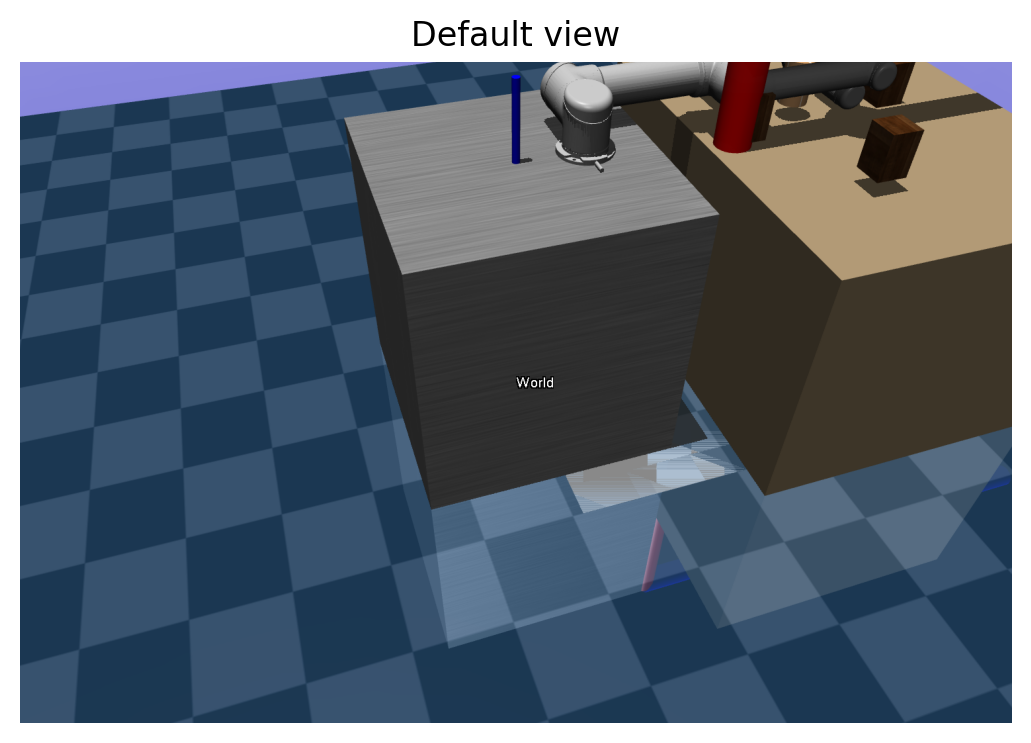

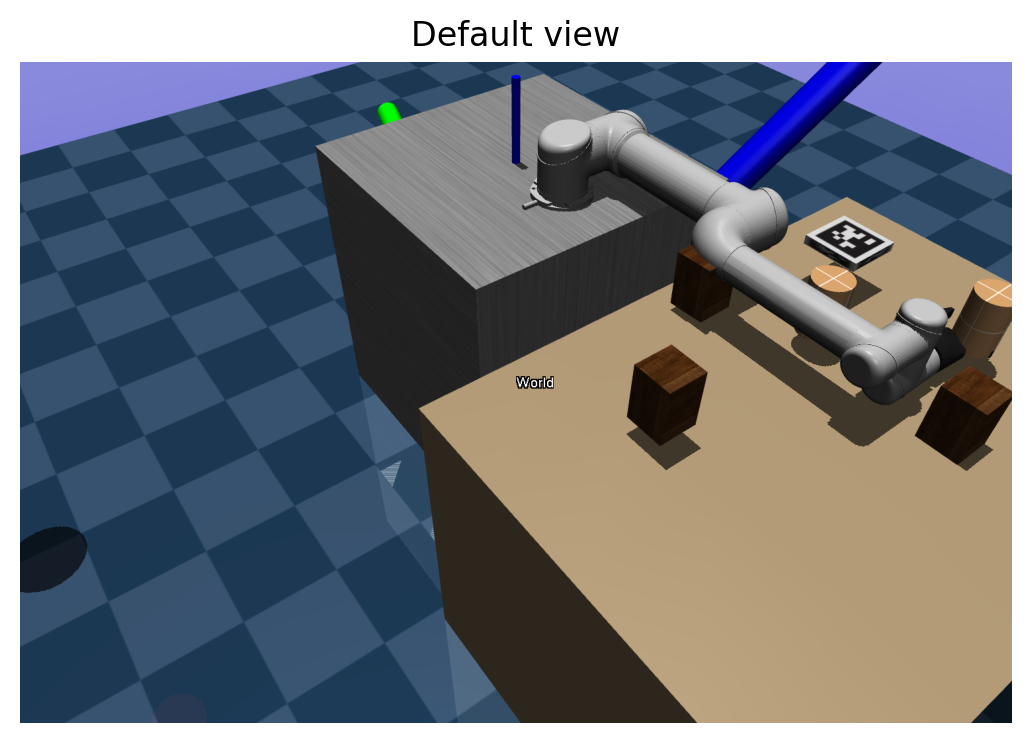

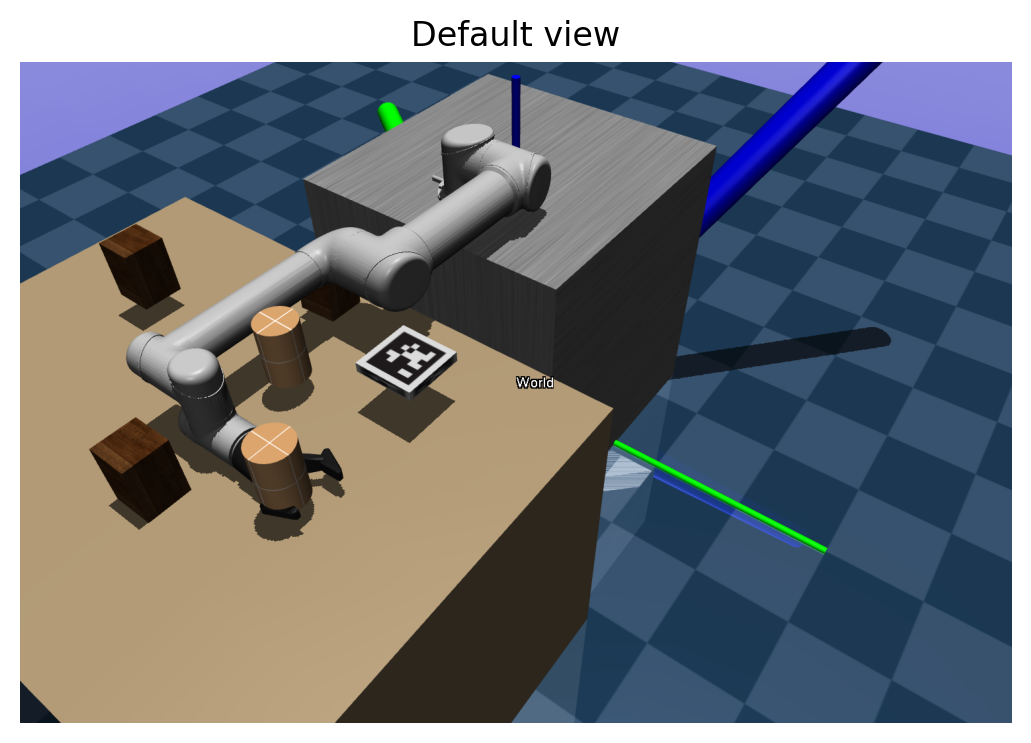

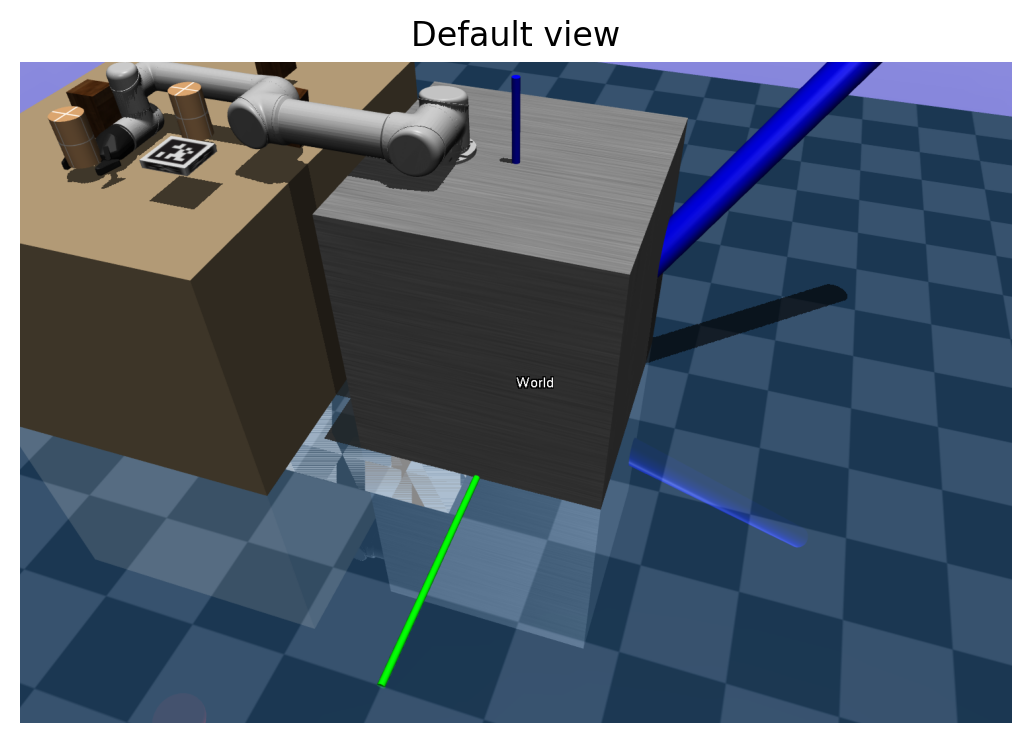

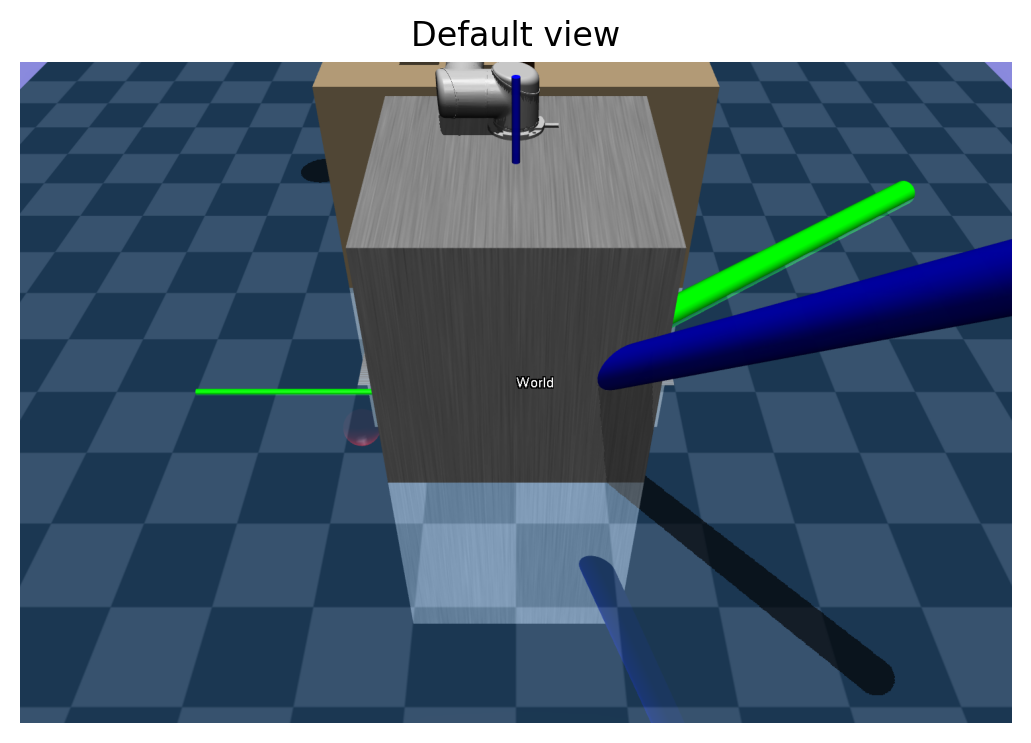

Done.


In [6]:
render_w = 1500
render_h = 1000

# Render
cam_infos = env.set_cam_infos(cam_azimuth   = 0,
        cam_distance  = 2.5,
        cam_elevation = -45, # -90~+90
        cam_lookat    = [0,0,0]
        )

env.reset()
max_tick = 5
while env.tick < max_tick:
    # Update
    env.step()
    
    # Get camera info
    if env.tick < 5:
        vi = env.get_viewer_info()
        p_viewer = vi['cam_lookat']
        R_viewer = rpy2r(np.deg2rad([0,-vi['cam_elevation'],vi['cam_azimuth']]))
        T_viewer = pr2t(p_viewer,R_viewer)
        T_marker = T_viewer @ pr2t(np.array([-2,0,0]),np.eye(3)) # minus translate w.r.t. x
        p_marker,R_marker = t2pr(T_marker)
    
    # Plot coordinate
    env.add_marker_coordinate(
        p=[0,0,0],R=np.eye(3),axis_len=1.0,axis_width=0.01,label='World')
    env.add_marker_coordinate(
        p=p_viewer,R=R_viewer,axis_len=2,axis_width=0.05,label='')
    env.add_marker_sphere(
        p=p_marker,radius=0.1,rgba=[1,0,0,1])
    
    # Render
    tick_rate = env.tick / max_tick
    MOVE_CAMERA = True
    if MOVE_CAMERA:
        # env.set_viewer(
        #     cam_azimuth   = 360.0*tick_rate,
        #     cam_elevation = 0.0*tick_rate - 45
        # )
        cam_infos = env.set_cam_infos(
            cam_azimuth   = 360.0*tick_rate,
            cam_elevation = 0.0*tick_rate - 45
        )
    # env.render() 

    for _ in range(2):
        img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=False, camera_name="track")

    plt.imshow(img); plt.axis('off')
    plt.title("Default view")
    plt.show()

    del env.viewer._markers[:]

    # for _ in range(10):
    #     img = env.viewer.read_pixels(width=render_w,height=render_h, depth=False)
    # img = cv2.flip(cv2.rotate(img,cv2.ROTATE_180),1) # 0:up<->down, 1:left<->right

    # plt.imshow(img)
    # plt.show()

print ("Done.")

### Display frames as Gif 

In [7]:
from matplotlib import animation
from IPython.display import display, HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_jshtml())

def display_frames_as_gif(frame_list, filename):
    patch = plt.imshow(frame_list[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frame_list[i])
    anim = animation.FuncAnimation(
        plt.gcf(),animate,frames=len(frame_list),interval=20)
    display(display_animation(anim))
    # plt.gcf().savefig("gifs.gif")
    animation.Animation.save(anim, filename, fps=30)
print ("Done.")

Done.


# AprilTag Detection

[UR5e] Instantiated.


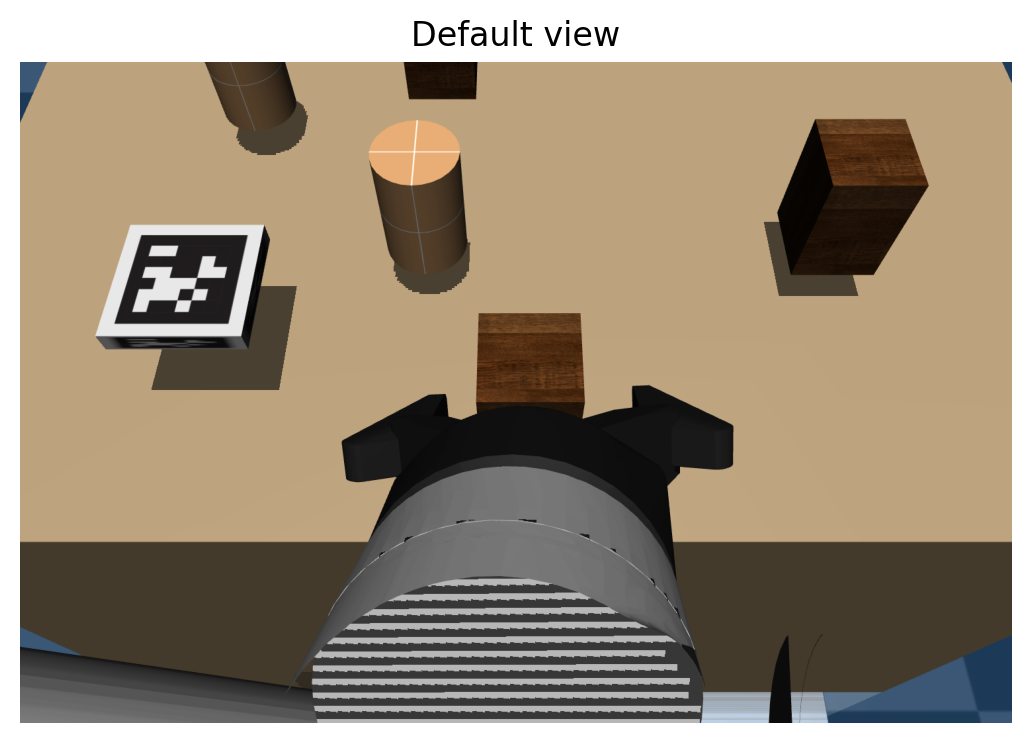

KeyboardInterrupt: 

In [8]:
import math
 
frame_list = []
ur_joint_idx = np.array([0, 1, 2, 3, 4, 5, 6], dtype=np.int32)

width = 1500
height = 1000

print ("[%s] Instantiated."%(env.name))
env.reset()

# Render
# ee_position = env.get_p_body("ee_link")
ee_position = env.get_p_body("robotiq_85_base_link")

# arbitrary offset about Robot Arm.
ee_position[2] = ee_position[2] + 0.1

cam_infos = env.set_cam_infos(
        cam_distance  = 0.1,
        cam_azimuth   = 0,    # azimuth:  z-axis
        cam_elevation = -60,    # -90~+90 elevation: y-axis
        cam_lookat    = ee_position
        )

# Init configuration.
env.sim.data.qpos[:8] = [-math.pi/2, -3*math.pi/4, 2*math.pi/3, 5*math.pi/9, math.pi/4, -math.pi/2, False, 0] 

for _ in range(5):
    img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=False, camera_name="track")

tick = 0 

while tick<100:    
    # if tick == 0:
    #     env.sim.data.qpos[:8] = [-math.pi/2, -6*math.pi/8, 2*math.pi/3, math.pi/2, math.pi/4, math.pi, 0, 0] 

    torque = [-math.pi/2, -6*math.pi/8, 2*math.pi/3, math.pi/2, math.pi/4, 0, False] 
    env.step(ctrl=torque, ctrl_idxs=ur_joint_idx)

    # Get camera info
    if env.tick < 5:
        vi = env.get_cam_infos()    # my code.
        # vi = env.get_viewer_info()
        p_viewer = vi['cam_lookat']
        R_viewer = rpy2r(np.deg2rad([0,-vi['cam_elevation'],vi['cam_azimuth']]))
        T_viewer = pr2t(p_viewer,R_viewer)
        T_marker = T_viewer @ pr2t(np.array([-2,0,0]),np.eye(3)) # minus translate w.r.t. x
        p_marker,R_marker = t2pr(T_marker)

    # Plot coordinate
    env.add_marker_coordinate(
        p=[0,0,0],R=np.eye(3),axis_len=1.0,axis_width=0.01,label='World')
    env.add_marker_coordinate(
        p=p_viewer,R=R_viewer,axis_len=2,axis_width=0.05,label='')
    env.add_marker_sphere(
        p=p_marker,radius=0.1,rgba=[1,0,0,1])

    # Render
    tick_rate = env.tick / max_tick
    MOVE_CAMERA = False
    if MOVE_CAMERA:
        cam_infos = env.set_cam_infos(
            cam_azimuth   = 360.0*tick_rate,
            cam_elevation = 0.0*tick_rate - 45
        )

    arm_follow = True
    if arm_follow:
        # ee_position = env.get_p_body("ee_link")
        ee_position = env.get_p_body("robotiq_85_base_link")
        # arbitrary offset about Robot Arm.
        ee_position[2] = ee_position[2] + 0.1
        
        cam_infos = env.set_cam_infos(
                cam_lookat    = ee_position
                )

    verbose = False
    if verbose:
        env.print_viewer_info()

    del env.viewer._markers[:]  # delete the markers that I created.

    # env.render_scene: render a scene and apply camera pose.
    for _ in range(2):
        img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=False, camera_name="track")

    if (tick % 20 == 0):
        plt.imshow(img); plt.axis('off')
        plt.title("Default view")
        plt.show()

    tick += 1
    frame_list.append(img)

env.terminate_viewer()
display_frames_as_gif(frame_list, "test-calibration-following-7.gif")


In [9]:
def draw_bbox(results, image, verbose=False):
    width = 1500
    height = 1000

    for r in results:
        # extract the bounding box (x, y)-coordinates for the AprilTag
        # and convert each of the (x, y)-coordinate pairs to integers
        (ptA, ptB, ptC, ptD) = r.corners
        ptB = (int(ptB[0]), int(ptB[1]))
        ptC = (int(ptC[0]), int(ptC[1]))
        ptD = (int(ptD[0]), int(ptD[1]))
        ptA = (int(ptA[0]), int(ptA[1]))

        # draw the bounding box of the AprilTag detection
        cv2.line(image, ptA, ptB, (0, 255, 0), 2)
        cv2.line(image, ptB, ptC, (0, 255, 0), 2)
        cv2.line(image, ptC, ptD, (0, 255, 0), 2)
        cv2.line(image, ptD, ptA, (0, 255, 0), 2)

        # draw the center (x, y)-coordinates of the AprilTag
        (cX, cY) = (int(r.center[0]), int(r.center[1]))
        cv2.circle(image, (cX, cY), 5, (0, 0, 255), -1)

        # draw the tag family on the image
        tagFamily = r.tag_family.decode("utf-8")
    
        if verbose == True:
            cv2.putText(image, tagFamily, (ptA[0], ptA[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 5.0, (255, 255, 255), 3)
            # print("Apriltag name: {}".format(tagFamily))

            x_centered = cX - width / 2
            y_centered = -1 * (cY - height / 2)

            cv2.putText(image, f"Center X coord: {x_centered}", (ptB[0] + 10, ptB[1] - 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, (125, 0, 125), 7)

            cv2.putText(image, f"Center Y coord: {y_centered}", (ptB[0] + 10, ptB[1]),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (125, 0, 125), 7)

            cv2.putText(image, f"Tag ID: {r.tag_id}", (ptC[0] - 70, ptC[1] - 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (125, 0, 125), 7)

        cv2.circle(image, (int((width / 2)), int((height / 2))), 5, (0, 0, 255), 2)

[UR5e] Instantiated.
init cam pose {'cam_distance': 0.05, 'cam_azimuth': 0, 'cam_elevation': -60, 'cam_lookat': array([0., 0., 0.])}
tick:0, cam pose {'cam_distance': 0.05, 'cam_azimuth': 0, 'cam_elevation': -60, 'cam_lookat': array([0.35, 0.01, 1.31])}


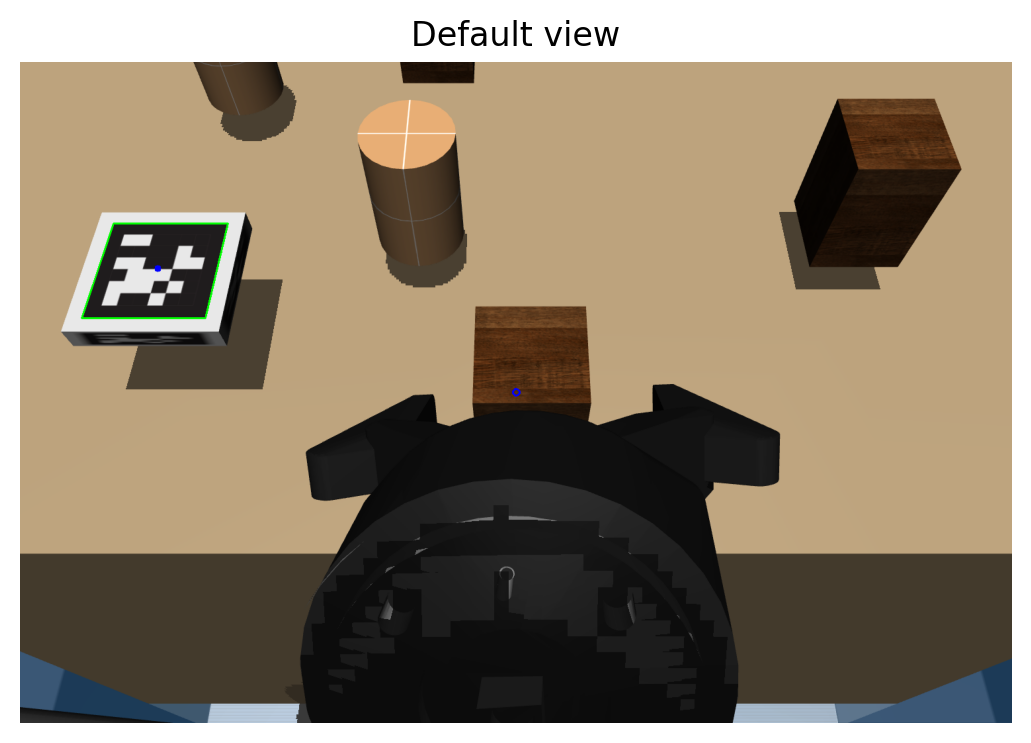

tick:1, cam pose {'cam_distance': 0.05, 'cam_azimuth': 0, 'cam_elevation': -60, 'cam_lookat': array([0.35, 0.01, 1.31])}
tick:2, cam pose {'cam_distance': 0.05, 'cam_azimuth': 0, 'cam_elevation': -60, 'cam_lookat': array([0.35, 0.01, 1.31])}
tick:3, cam pose {'cam_distance': 0.05, 'cam_azimuth': 0, 'cam_elevation': -60, 'cam_lookat': array([0.34, 0.01, 1.31])}
tick:4, cam pose {'cam_distance': 0.05, 'cam_azimuth': 0, 'cam_elevation': -60, 'cam_lookat': array([0.34, 0.01, 1.3 ])}


KeyboardInterrupt: 

In [10]:
import math
import apriltag

detector = apriltag.Detector()

frame_list = []
ur_joint_idx = np.array([0, 1, 2, 3, 4, 5, 6], dtype=np.int32)

width = 1500
height = 1000

print ("[%s] Instantiated."%(env.name))
env.reset()

# Render
ee_position = env.get_p_body("robotiq_85_base_link")

cam_infos = env.set_cam_infos(
        cam_distance  = 0.05,
        cam_azimuth   = 0,    # azimuth:  z-axis
        cam_elevation = -60,    # -90~+90 elevation: y-axis
        cam_lookat    = ee_position
        )
print(f"init cam pose {cam_infos}")

# Init configuration.
env.sim.data.qpos[:8] = [-math.pi/2, -3*math.pi/4, 2*math.pi/3, 5*math.pi/9, math.pi/4, -math.pi/2, False, 0] 

for _ in range(5):
    img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=False, camera_name="track")

tick = 0 

while tick<100:    
    # if tick == 0:
    #     env.sim.data.qpos[:8] = [-math.pi/2, -6*math.pi/8, 2*math.pi/3, math.pi/2, math.pi/4, math.pi, 0, 0] 

    torque = [-math.pi/2, -6*math.pi/8, 2*math.pi/3, math.pi/2, math.pi/4, 0, False] 
    env.step(ctrl=torque, ctrl_idxs=ur_joint_idx)

    # Get camera info
    if env.tick < 5:
        vi = env.get_cam_infos()    # my code.
        # vi = env.get_viewer_info()
        p_viewer = vi['cam_lookat']
        R_viewer = rpy2r(np.deg2rad([0,-vi['cam_elevation'],vi['cam_azimuth']]))
        T_viewer = pr2t(p_viewer,R_viewer)
        T_marker = T_viewer @ pr2t(np.array([-2,0,0]),np.eye(3)) # minus translate w.r.t. x
        p_marker,R_marker = t2pr(T_marker)

    # Plot coordinate
    env.add_marker_coordinate(
        p=[0,0,0],R=np.eye(3),axis_len=1.0,axis_width=0.01,label='World')
    env.add_marker_coordinate(
        p=p_viewer,R=R_viewer,axis_len=2,axis_width=0.05,label='')
    env.add_marker_sphere(
        p=p_marker,radius=0.1,rgba=[1,0,0,1])

    # Render
    tick_rate = env.tick / max_tick
    MOVE_CAMERA = False
    if MOVE_CAMERA:
        cam_infos = env.set_cam_infos(
            cam_azimuth   = 360.0*tick_rate,
            cam_elevation = 0.0*tick_rate - 45
        )

    arm_follow = True
    if arm_follow:
        # ee_position = env.get_p_body("ee_link")
        ee_position = env.get_p_body("robotiq_85_base_link")
        # arbitrary offset about Robot Arm.
        ee_position[2] = ee_position[2] + 0.1
        
        cam_infos = env.set_cam_infos(
                cam_lookat    = ee_position
                )
    print(f"tick:{tick}, cam pose {cam_infos}")

    verbose = False
    if verbose:
        env.print_viewer_info()

    del env.viewer._markers[:]  # delete the markers that I created.

    # env.render_scene: render a scene and apply camera pose.
    for _ in range(2):
        img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=False, camera_name="track")

    img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_Gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)

    # detections, dimg = detector.detect(fram_gray, return_image=True)
    results = detector.detect(img_Gray)
    # print(results)

    cam_matrix, _, _ = env.camera_matrix_and_pose(width=render_w, height=render_h, camera_name="main1")
    fx = cam_matrix[0][0]
    cx = cam_matrix[0][2]
    fy = cam_matrix[1][1]
    cy = cam_matrix[1][2]

    cam_params = [fx, fy, cx, cy]

    # Render the detections on the image
    if len(results) > 0:
        draw_bbox(results, img, verbose)

        for r in results:
            pose, e0, e1 = detector.detection_pose(detection=r, camera_params=cam_params, tag_size=0.06)
            
            poseRotation = pose[:3]
            poseTranslation = pose[3]

    if (tick % 20 == 0):
        plt.imshow(img); plt.axis('off')
        plt.title("Default view")
        plt.show()

    tick += 1
    frame_list.append(img)

# env.terminate_viewer()
display_frames_as_gif(frame_list, "test-calibration-apriltag-2.gif")

In [22]:
pose

array([[ 0.  ,  1.  ,  0.01, -0.14],
       [-0.87,  0.  ,  0.49, -0.08],
       [ 0.49, -0.01,  0.87,  0.38],
       [ 0.  ,  0.  ,  0.  ,  1.  ]])

In [13]:
print(dir(detector))


['__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_convert_image', '_declare_return_types', '_vis_detections', 'add_tag_family', 'detect', 'detection_pose', 'families', 'libc', 'options', 'tag_detector']
